# Mouse Aging 10X RNA-seq gene expression  

In this notebook we'll explore some gene expressions and combine them with the cell metadata we showed in the previous [clustering analysis tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/Zeng_Aging_Mouse_clustering_analysis_and_annotation.html).

You need to be either connected to the internet or connected to a cache that has the aging data downloaded already and have already downloaded the example data via the getting started notebook to run this notebook. 

In [1]:
import pandas as pd
import numpy as np
import anndata
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from typing import Optional, Tuple

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas Dataframe. See the [``getting_started``](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) notebook for more details on using the cache including installing it if it has not already been. 

**Change the download_base variable to where you have downloaded the data in your system.** 

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20250331/manifest.json'

Create the expanded cell metadata as was done previously in the [cluster annotation tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/Zeng_Aging_Mouse_clustering_analysis_and_annotation.html). 

In [3]:
# Load the cell metadata.
cell = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cell_metadata',
    dtype={'cell_label': str,
           'wmb_cluster_alias': 'Int64'}
)
cell.set_index('cell_label', inplace=True)

cell_colors = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cell_annotation_colors'
).set_index('cell_label')

cluster_info = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cluster'
).set_index('cluster_alias')

cell_cluster_mapping = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-WMB-taxonomy',
    file_name='cell_cluster_mapping_annotations'
).set_index('cell_label')
cell_cluster_mapping.head()

# Join on the cell_label index.
cell_extended = cell.join(cell_cluster_mapping, rsuffix='_cl_map')
cell_extended = cell_extended.join(cell_colors, rsuffix='_cl_colors')
# Join the cluster information in by joining on the Aging dataset's cluster_alias column.
cell_extended = cell_extended.join(cluster_info, on='cluster_alias', rsuffix='_cl_info')

# Quick run through to drop duplicated columns
drop_cols = []
for col in cell_extended.columns:
    if col.endswith(('_cl_map', '_cl_colors', '_cl_info')):
        drop_cols.append(col)
cell_extended.drop(columns=drop_cols, inplace=True)

# The dataset is sorted on cell_label by default, this causes some plotting weirdness
# due to all "adult" cells being first in the order. Below we scrabble the DataFrame
# to better reproduce plots from the paper.
cell_extended = cell_extended.sample(frac=1, random_state=12345)

del cell
del cell_colors
del cell_cluster_mapping
del cluster_info

cell_extended.head()

cell_metadata.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 419M/419M [00:58<00:00, 7.12MMB/s]
cell_annotation_colors.csv: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 76.1M/76.1M [00:10<00:00, 7.35MMB/s]
cluster.csv: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174k/174k [00:00<00:00, 1.34MMB/s]
cell_cluster_mapping_annotations.csv: 100%|███████████████████████████████████████████████████████████████████████████████████████| 173M/173M [00:24<00:00, 7.20MMB/s]


,cell_barcode,gene_count,umi_count,doublet_score,x,y,cluster_alias,cell_in_wmb_study,wmb_cluster_alias,library_label,...,proportion_adult_cells,proportion_aged_cells,odds_ratio,log2_odds_ratio,cluster_age_bias,max_region_of_interest_color,cluster_age_bias_color,neurotransmitter_combined_label,neurotransmitter_label,neurotransmitter_color
cell_label,,,,,,,,,,,,,,,,,,,,,
GCCTGTTGTGAATTAG-135_B01,GCCTGTTGTGAATTAG,6777,37834.0,0.200000,-1.185296,1.881103,278,True,1079,L8TX_190716_01_D07,...,0.577949,0.422051,1.013716,0.019653,unassigned,#80CDF8,#DADEDF,GABA,GABA,#FF3358
TCCGAAAGTGAAGCGT-761_A04,TCCGAAAGTGAAGCGT,3396,9585.0,0.030303,14.007499,-0.220336,817,False,<NA>,L8TX_210805_01_H01,...,0.454494,0.545506,1.046448,0.065500,unassigned,#8599CC,#DADEDF,No-NT,No-NT,#666666
TTACCATGTCGTGGTC-327_A06,TTACCATGTCGTGGTC,4294,10527.0,0.020000,6.550781,-1.378886,804,False,<NA>,L8TX_200813_01_H10,...,0.370570,0.629430,1.741208,0.800089,unassigned,#80C0E2,#DADEDF,No-NT,No-NT,#666666
ACGGGTCGTACGAGCA-385_D06,ACGGGTCGTACGAGCA,2943,6957.0,0.000000,13.650183,0.289086,817,False,<NA>,L8TX_201008_01_A12,...,0.454494,0.545506,1.046448,0.065500,unassigned,#8599CC,#DADEDF,No-NT,No-NT,#666666
CTTAGGATCTGTCCCA-301_B04,CTTAGGATCTGTCCCA,7907,47406.0,0.037037,6.583878,-10.639808,152,False,<NA>,L8TX_200723_01_B10,...,0.403409,0.596591,0.587232,-0.767999,unassigned,#72D569,#DADEDF,Glut,Glut,#2B93DF


## Single cell transcriptomes 

The ~1.2 million cell dataset of Aging Mouse is contained in one gene expression matrix for each of the raw and log2 normalized data. Each matrix file is formatted as an annadata, h5ad file with minimal metadata. 

Below we show some interactions with data from the 10X expression matrices in the Aging Mouse dataset. For a deeper dive into how to access specific gene data from the expression matrices, se the [``general_acessing_10x_snRNASeq_tutorial.ipynb``](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html) notebook. Below we will use precomputed metadata from these matrices to look at gene expression both in relation to different neurotransmitters and locations across the brain. 

First, we list the available metadata in the Zeng-Aging-Mouse-10Xv3 dataset again. The file we will be using in this part of the tutorial is the ``example_genes_all_cells_expression`` table. We will load the genes from the WMB-10X dataset as the genes for the aging data are identical.

The table below holds metadata for all genes sequenced in the dataset.

In [4]:
gene = abc_cache.get_metadata_dataframe(directory='WMB-10X', file_name='gene').set_index('gene_identifier')
print("Number of genes = ", len(gene))
gene.head(5)

gene.csv: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.30M/2.30M [00:00<00:00, 6.90MMB/s]

Number of genes =  32285


,gene_symbol,name,mapped_ncbi_identifier,comment
gene_identifier,,,,
ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,NCBIGene:497097,NaN
ENSMUSG00000089699,Gm1992,predicted gene 1992,NaN,NaN
ENSMUSG00000102331,Gm19938,"predicted gene, 19938",NaN,NaN
ENSMUSG00000102343,Gm37381,"predicted gene, 37381",NaN,NaN
ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human),NCBIGene:19888,NaN


We'll skip accessing these data from the expression matrices specifically for now, however, users can learn how to access specific genes from the released expression matrices in the[``general_acessing_10x_snRNASeq_tutorial.ipynb``](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html) notebook. 

The precomputed table below contains expressions for the genes Slc17a7, Slc17a6, Slc17a8, Slc32a1, Slc6a5, Slc6a3, Slc6a4, and 'Tac2 for all cells across the Aging Mouse dataset. We then join this with our previously created cell_extended pandas DataFrame from this tutorial. 

In [5]:
gene_names = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc6a3', 'Slc6a4', 'Tac2']
example_genes = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='example_genes_all_cells_expression'
).set_index('cell_label')

example_genes_all_cells_expression.csv: 100%|███████████████████████████████████████████████████████████████████████████████████| 77.0M/77.0M [00:11<00:00, 6.72MMB/s]


In [6]:
cell_extended_with_genes = cell_extended.join(example_genes)
cell_extended_with_genes.head()

,cell_barcode,gene_count,umi_count,doublet_score,x,y,cluster_alias,cell_in_wmb_study,wmb_cluster_alias,library_label,...,neurotransmitter_label,neurotransmitter_color,Slc32a1,Slc17a7,Slc6a5,Slc17a6,Slc17a8,Tac2,Slc6a4,Slc6a3
cell_label,,,,,,,,,,,,,,,,,,,,,
GCCTGTTGTGAATTAG-135_B01,GCCTGTTGTGAATTAG,6777,37834.0,0.200000,-1.185296,1.881103,278,True,1079,L8TX_190716_01_D07,...,GABA,#FF3358,7.900150,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
TCCGAAAGTGAAGCGT-761_A04,TCCGAAAGTGAAGCGT,3396,9585.0,0.030303,14.007499,-0.220336,817,False,<NA>,L8TX_210805_01_H01,...,No-NT,#666666,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
TTACCATGTCGTGGTC-327_A06,TTACCATGTCGTGGTC,4294,10527.0,0.020000,6.550781,-1.378886,804,False,<NA>,L8TX_200813_01_H10,...,No-NT,#666666,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
ACGGGTCGTACGAGCA-385_D06,ACGGGTCGTACGAGCA,2943,6957.0,0.000000,13.650183,0.289086,817,False,<NA>,L8TX_201008_01_A12,...,No-NT,#666666,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
CTTAGGATCTGTCCCA-301_B04,CTTAGGATCTGTCCCA,7907,47406.0,0.037037,6.583878,-10.639808,152,False,<NA>,L8TX_200723_01_B10,...,Glut,#2B93DF,4.465607,8.794357,0.0,7.864422,0.0,0.0,0.0,0.0


## Example use cases

During analysis, clusters were assigned neurotransmitter identities based on the expression of canonical neurotransmitter transporter genes. In this example, we create a DataFrame comprising of expression of the 9 solute carrier family genes for all the cells in the dataset.  We then group the cells by the assigned neurotransmitter class and compute the mean expression for each group. We will define a simple helper function to visualize the expression as a heatmap. 

Below we define a helper function *aggregate_by_metadata* to compute the average expression for a given category and later *plot_umap* to plot cells in a UMAP colorized by metadata or expression values like what was used in the [previous tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/Zeng_Aging_Mouse_clustering_analysis_and_annotation.html).

In [7]:
def aggregate_by_metadata(df, gnames, value, sort = False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

### Expression of selected genes in the whole brain

The helper function below creates a heatmap showing the relation between various parameters in the combined cell metadata and the genes we loaded. For the default colormap used, darker colors equate to a higher expression.

In [8]:
def plot_heatmap(df, fig_width=8, fig_height=4, cmap=plt.cm.magma_r, vmin=None, vmax=None) :

    arr = df.to_numpy().astype('float')

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    im = ax.imshow(arr, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)
    
    return im

Below, we plot the expression of the genes we’ve selected for this example. We show the genes vs neurotransmitter type/identity. As expected, the genes associated with the various neurotransmitter express as expected. 

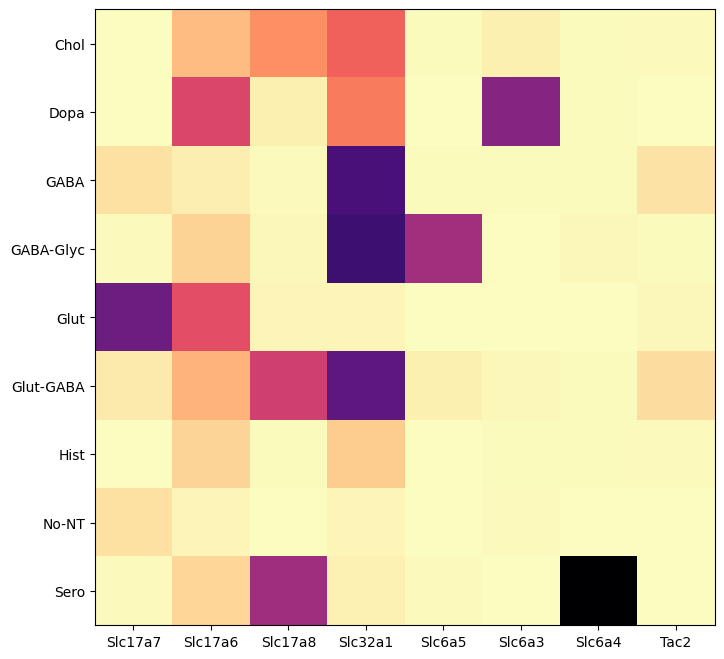

In [9]:
agg = aggregate_by_metadata(cell_extended_with_genes, gene_names, 'neurotransmitter_label')
res = plot_heatmap(agg, 8, 8)
plt.show()

By dissection region of interest shows that each of these genes are associated with distinct regions. 

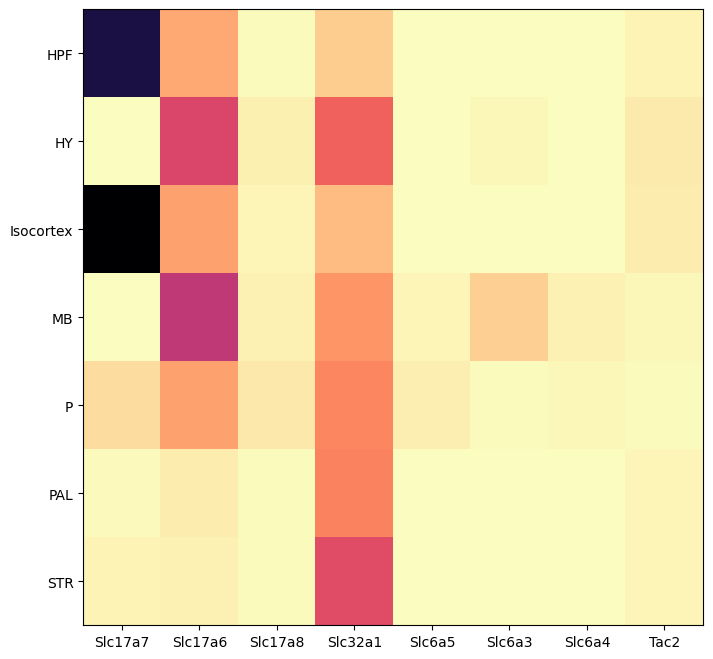

In [10]:
agg = aggregate_by_metadata(cell_extended_with_genes, gene_names, 'anatomical_division_label')
res = plot_heatmap(agg, 8, 8)
plt.show()

And finally, by class from the taxonomy. 

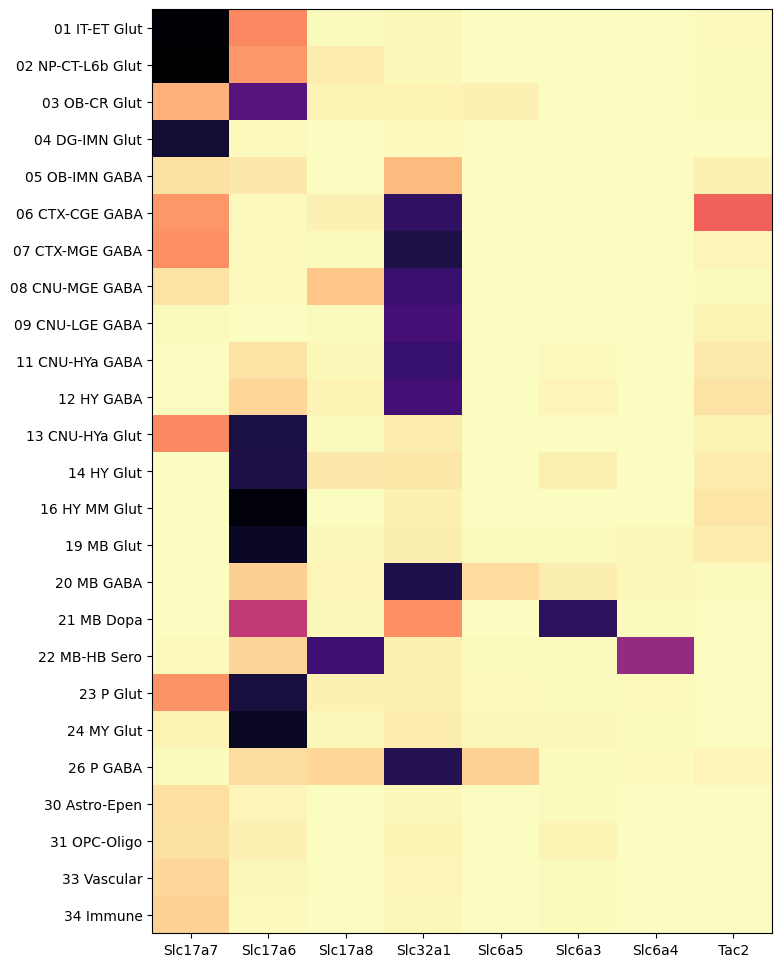

In [11]:
agg = aggregate_by_metadata(cell_extended_with_genes, gene_names, 'class_name')
res = plot_heatmap(agg, 8, 12)
plt.show()

We can also visualize the relationship between these genes and their location in the UMAP.

In [12]:
def plot_umap(xx, yy, cc=None, val=None, fig_width=8, fig_height=8, cmap=None):

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None :
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    ax.axis('equal')
    # ax.set_xlim(-18, 27)
    # ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

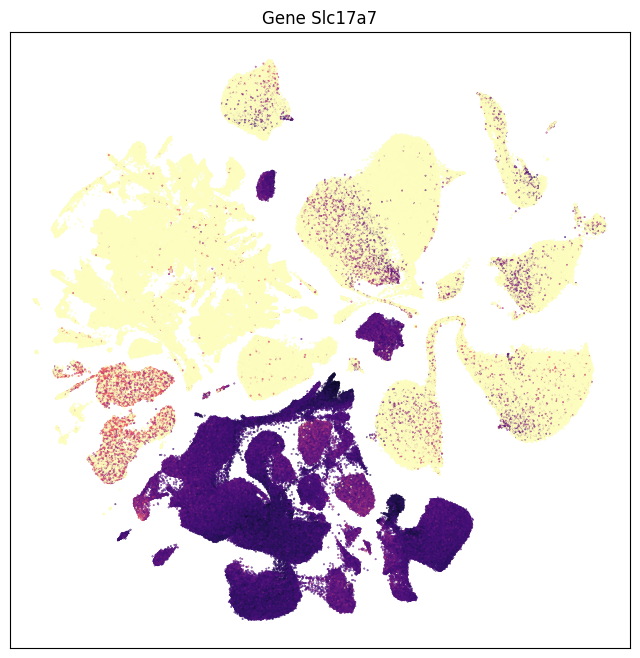

In [13]:
for gene_name in gene_names:
    fig, ax = plot_umap(
        cell_extended_with_genes['x'],
        cell_extended_with_genes['y'],
        val=cell_extended_with_genes[gene_name],
        cmap=plt.cm.magma_r)
    res = ax.set_title(f"Gene {gene_name}")
    plt.show()
    break # Remove break statement to see all selected genes

## AgeDE Genes 

The Aging Mouse data also provides a set of aging Differential Expression (ageDE) genes at various levels of the taxonomy. The table is presented as a flattened set of ageDE genes found within a specific cell type where each row is a unique gene/celltype combination. Note that for a given level in the taxonomy, only certain cell types have significant ageDE genes reported. For instance, the supertype level in the aging_degenes table only contains non-neuronal cell types. 

Below we load and display this table. 

In [14]:
degenes = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-WMB-taxonomy',
    file_name='aging_degenes'
)
degenes.head()

aging_degenes.csv: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.13M/1.13M [00:00<00:00, 5.50MMB/s]


,grouping_type,grouping_label,grouping_name,gene_identifier,gene_symbol,is_primary_ieg,age_effect_size,unadjusted_pvalue,adjusted_pvalue,confidence_interval_higher_bound,confidence_interval_lower_bound
0,subclass,CS20230722_SUBC_100,100 AHN Onecut3 Gaba,ENSMUSG00000073590,3222401L13Rik,False,1.812935,7.766049e-12,9.653199e-08,2.346020,1.279850
1,subclass,CS20230722_SUBC_100,100 AHN Onecut3 Gaba,ENSMUSG00000095041,AC149090.1,False,1.289552,3.322308e-17,4.129629e-13,1.793447,0.785656
2,subclass,CS20230722_SUBC_100,100 AHN Onecut3 Gaba,ENSMUSG00000086503,Xist,False,1.185049,2.222176e-11,2.762165e-07,1.645855,0.724244
3,subclass,CS20230722_SUBC_132,132 AHN-RCH-LHA Otp Fezf1 Glut,ENSMUSG00000073590,3222401L13Rik,False,1.867499,1.532389e-15,1.963297e-11,2.366093,1.368905
4,subclass,CS20230722_SUBC_132,132 AHN-RCH-LHA Otp Fezf1 Glut,ENSMUSG00000095041,AC149090.1,False,1.229435,4.989205e-25,6.392170e-21,1.589657,0.869213


Additionally, we load a mapping of all clusters to the levels higher in the taxonomy complete with their colors.

In [15]:
# mapping = pd.read_csv(taxonomy_base / 'cluster_mapping_pivot.csv' )
mapping = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-WMB-taxonomy',
    file_name='cluster_mapping_pivot'
)
mapping.head()

cluster_mapping_pivot.csv: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 118k/118k [00:00<00:00, 862kMB/s]


,cluster_alias,cluster_label,cluster_order,cluster_name,cluster_color,class_name,subclass_name,supertype_name,class_color,subclass_color,supertype_color
0,1,CS20241021_0001,0,1_CLA-EPd-CTX Car3 Glut_1,#f7c27a,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,0001 CLA-EPd-CTX Car3 Glut_1,#FA0087,#64c2fc,#99822E
1,2,CS20241021_0002,1,2_IT EP-CLA Glut_1,#5c1a34,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563
2,3,CS20241021_0003,2,3_IT EP-CLA Glut_1,#b96cf0,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563
3,4,CS20241021_0004,3,4_IT EP-CLA Glut_1,#bff691,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563
4,5,CS20241021_0005,4,5_IT EP-CLA Glut_1,#39fbfa,01 IT-ET Glut,002 IT EP-CLA Glut,0003 IT EP-CLA Glut_1,#FA0087,#1F665D,#994563


## ageDE vs supertype/subclass/cluster 

We declare a convenience function for working with our two tables above. This calculates the number of ageDE genes for a selected level in the taxonomy (cluster, supertype, subclass) and plots them as a bar graph. 

In [16]:
def plot_de_gene_count_by_taxonomy(
        mapping_df: pd.DataFrame,
        degene_df: pd.DataFrame,
        level_name: str,
        color_name: str,
        title: Optional[str]=None,
        classes: Optional[list[str]]=None,
        xlim: Tuple[int, int]=(0, 400),
        figsize: Tuple[int, int]=(3.5, 8)
) -> pd.DataFrame:
    """Plot ageDE genes grouped by cluser, supertype, subclass.

    Parameters
    ----------
    mapping_df: pandas.DataFrame
        DataFrame mapping of cluster to higher taxonomy levels with colors.
    degene_df: pandas.DataFrame
        DataFrame of ageDE genes with their associated cell type.
    level_name: str
        Name of taxonomy level to plot.
    color_name: str
        The name of the column to color by.
    title: str
        Title to add to the plot
    classes: list of str
        Plot only selected classes instead of all data.
    xlim: tuple of ints
        Plot limit on the x axis.
    figsize: tuple of float
        Plot size in inches.
    """
    # Get our colors
    color_map = mapping_df[[level_name, color_name, 'class_name']].copy()
    color_map.drop_duplicates(inplace=True)
    color_map.set_index(level_name, inplace=True)

    # Get counts for level (e.g. supertype_name)
    grouped = degene_df.groupby(['grouping_type', 'grouping_name'])['gene_symbol'].count()[level_name.split('_')[0]]

    # Setup our figure
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(figsize[0], figsize[1])

    class_map = []
    for name in grouped.index.values:
        submapping = mapping[mapping[level_name] == name].iloc[0]
        class_map.append({
            "grouping_name": name,
            "class_name": submapping['class_name'],
        })
    class_map = pd.DataFrame(data=class_map).set_index("grouping_name")

    if classes:
        class_mask = class_map[class_map['class_name'].isin(classes)].index.values
    else:
        class_mask = grouped.index.values
    
    counts = grouped.loc[class_mask].values[::-1]
    names = grouped.loc[class_mask].index.values[::-1]
    colors = color_map.loc[names, color_name].values

    # plot
    ax.barh(names, counts, color=colors)
    ax.set_xlim([xlim[0], xlim[1]])
    # ax.set_ylim([0, max_n_bars])
    ax.set_title(title)
    plt.show()

### vs Non-neuronal supertype

We'll use groupby over supertype to plot the non-neuronal ageDE genes colored by class.

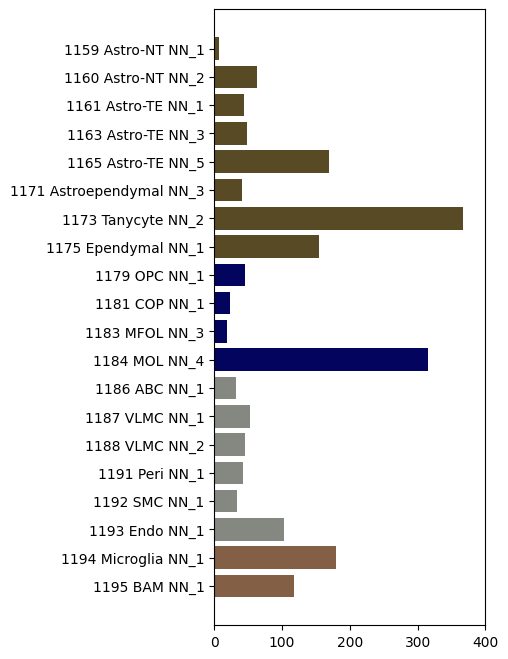

In [17]:
plot_de_gene_count_by_taxonomy(
    mapping_df=mapping,
    degene_df=degenes,
    level_name='supertype_name',
    color_name='class_color'
)

### vs Neuronal subclasses 

And now the same but this time for two of the subclasses. We plot only subclasses from classes, 12 HY GABA and 14 HY Glut for readablity of the plot. Add or select other classes to plot those as well.

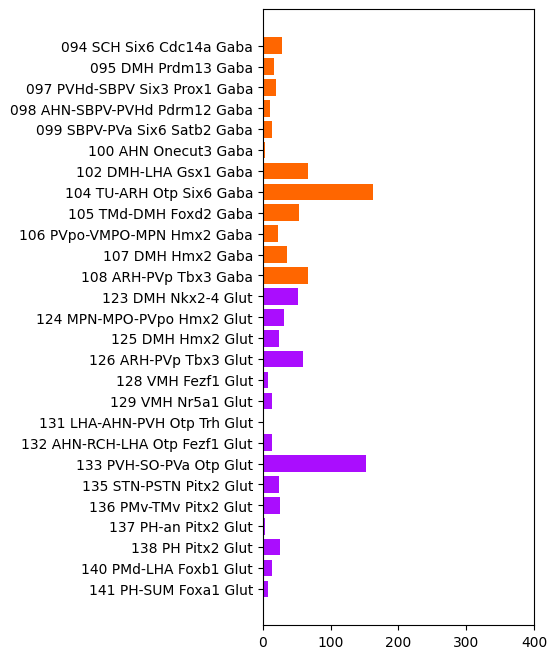

In [18]:
plot_de_gene_count_by_taxonomy(
    mapping_df=mapping,
    degene_df=degenes,
    level_name='subclass_name',
    color_name='class_color',
    figsize=(3.5, 8),
    classes=['12 HY GABA', '14 HY Glut']
)

### vs Neuronal clusters 

And now the same but this time for the neuronal clusters. We plot only clusters from the class 12 HY GABA again for readablity of the plot.

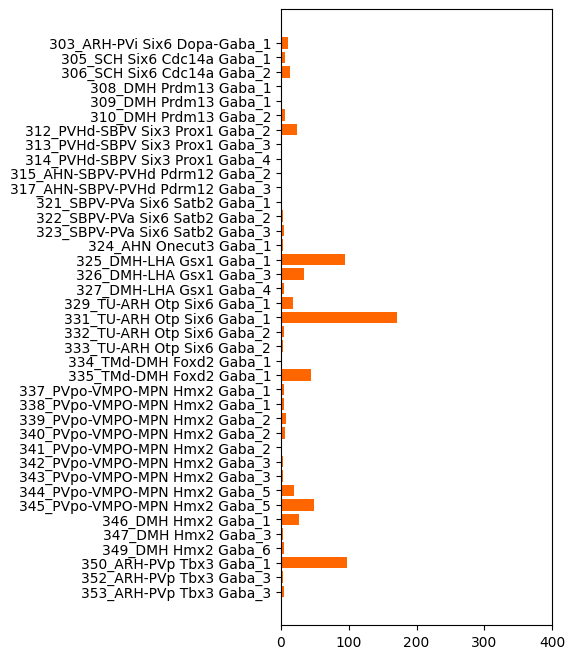

In [19]:
plot_de_gene_count_by_taxonomy(
    mapping_df=mapping,
    degene_df=degenes,
    level_name='cluster_name',
    color_name='class_color',
    figsize=(3.5, 8),
    classes=['12 HY GABA']
)

### Top N ageDE genes.

We'll write a quick function to extract the top N genes by p-value for a given supertype, subclass etc. and display the new, smaller ageDE gene table.

In [20]:
def top_ageDE_genes(
    degene_df: pd.DataFrame,
    level: Optional[str]=None,
    top_n: int=3
):
    if level is None:
        level_degenes = degene_df
    else:
        level_degenes = degene_df[degene_df['grouping_type'] == level]

    output_df = []
    celltypes = level_degenes['grouping_name'].unique()
    for celltype in celltypes:
        subdf = degenes[degenes['grouping_name'] == celltype].sort_values(by='adjusted_pvalue')
        if len(subdf) < top_n:
            output_df.append(subdf)
        else:
            output_df.append(subdf[:top_n])
    return pd.concat(output_df).reset_index(drop=True)

Below we'll grab the top 5 genes for all the supertypes. We'll show only the first 5 rows of the new table. This shows the top 5 genes by adjusted p_value for 1186 ABC NN_1. This analysis can be repeated for any top N genes and any of the celltype taxonomy levels.

In [21]:
top_ageDE = top_ageDE_genes(degene_df=degenes, level='supertype', top_n=5)
top_ageDE.head()

,grouping_type,grouping_label,grouping_name,gene_identifier,gene_symbol,is_primary_ieg,age_effect_size,unadjusted_pvalue,adjusted_pvalue,confidence_interval_higher_bound,confidence_interval_lower_bound
0,supertype,CS20230722_SUPT_1186,1186 ABC NN_1,ENSMUSG00000052477,C130026I21Rik,False,2.714264,4.619190e-26,4.841834e-22,3.369042,2.059486
1,supertype,CS20230722_SUPT_1186,1186 ABC NN_1,ENSMUSG00000000184,Ccnd2,False,-3.401134,1.515504e-24,1.588551e-20,-2.796106,-4.006162
2,supertype,CS20230722_SUPT_1186,1186 ABC NN_1,ENSMUSG00000024610,Cd74,False,3.550094,8.157661e-22,8.550860e-18,4.268748,2.831439
3,supertype,CS20230722_SUPT_1186,1186 ABC NN_1,ENSMUSG00000036594,H2-Aa,False,2.852235,3.852163e-18,4.037837e-14,3.502760,2.201709
4,supertype,CS20230722_SUPT_1186,1186 ABC NN_1,ENSMUSG00000060586,H2-Eb1,False,2.467009,3.964547e-16,4.155638e-12,3.097659,1.836359


### Select ageDE expression vs subclass  

Next we'll plot the expression of a select set of ageDE genes vs the subclasses in the taxonomy. The genes we select here are a subset of the those plotted in Extended Figure 7 from [Jin et al.], however one could plot all ageDE genes by modifying the degene_list. Note also that the ordering of the subclasses is different then the ordering in that plot. 

First we'll declare a function to extract the specific genes and celltype level we would like to plot.

In [22]:
def get_genes_for_celltype_level(
    degene_df: pd.DataFrame,
    level: str,
    degene_list: list[str],
):
    level_degenes = degene_df[degene_df['grouping_type'] == level]
    levels = sorted(level_degenes['grouping_name'].unique())
    level_by_gene = pd.DataFrame(columns=degene_list, index=levels)
    for idx, derow in level_degenes.iterrows():
        if derow['gene_symbol'] in degene_list:
            level_by_gene.loc[derow['grouping_name'], derow['gene_symbol']] = derow['age_effect_size']
    return level_by_gene

Let's first plot a select set of genes for the subclasses in the ageDE gene expression table. Note that that you can modify the list of genes to plot any subset or the full set of genes in the ageDE expression table by specifying the gene symbol.

In [23]:
subclass_by_gene = get_genes_for_celltype_level(
    degene_df=degenes,
    level='subclass',
    degene_list=['3222401L13Rik', 'Slc5a5', 'AC149090.1', 'Ccnd1', 'Ccnd2']
)
subclass_by_gene.head()

,3222401L13Rik,Slc5a5,AC149090.1,Ccnd1,Ccnd2
001 CLA-EPd-CTX Car3 Glut,NaN,NaN,1.614551,NaN,NaN
002 IT EP-CLA Glut,NaN,1.096541,NaN,-2.573835,-1.277657
003 L5/6 IT TPE-ENT Glut,NaN,1.253065,1.909579,-1.420208,NaN
004 L6 IT CTX Glut,NaN,NaN,1.535055,-1.5732,-1.371331
005 L5 IT CTX Glut,NaN,1.886562,1.530523,NaN,NaN


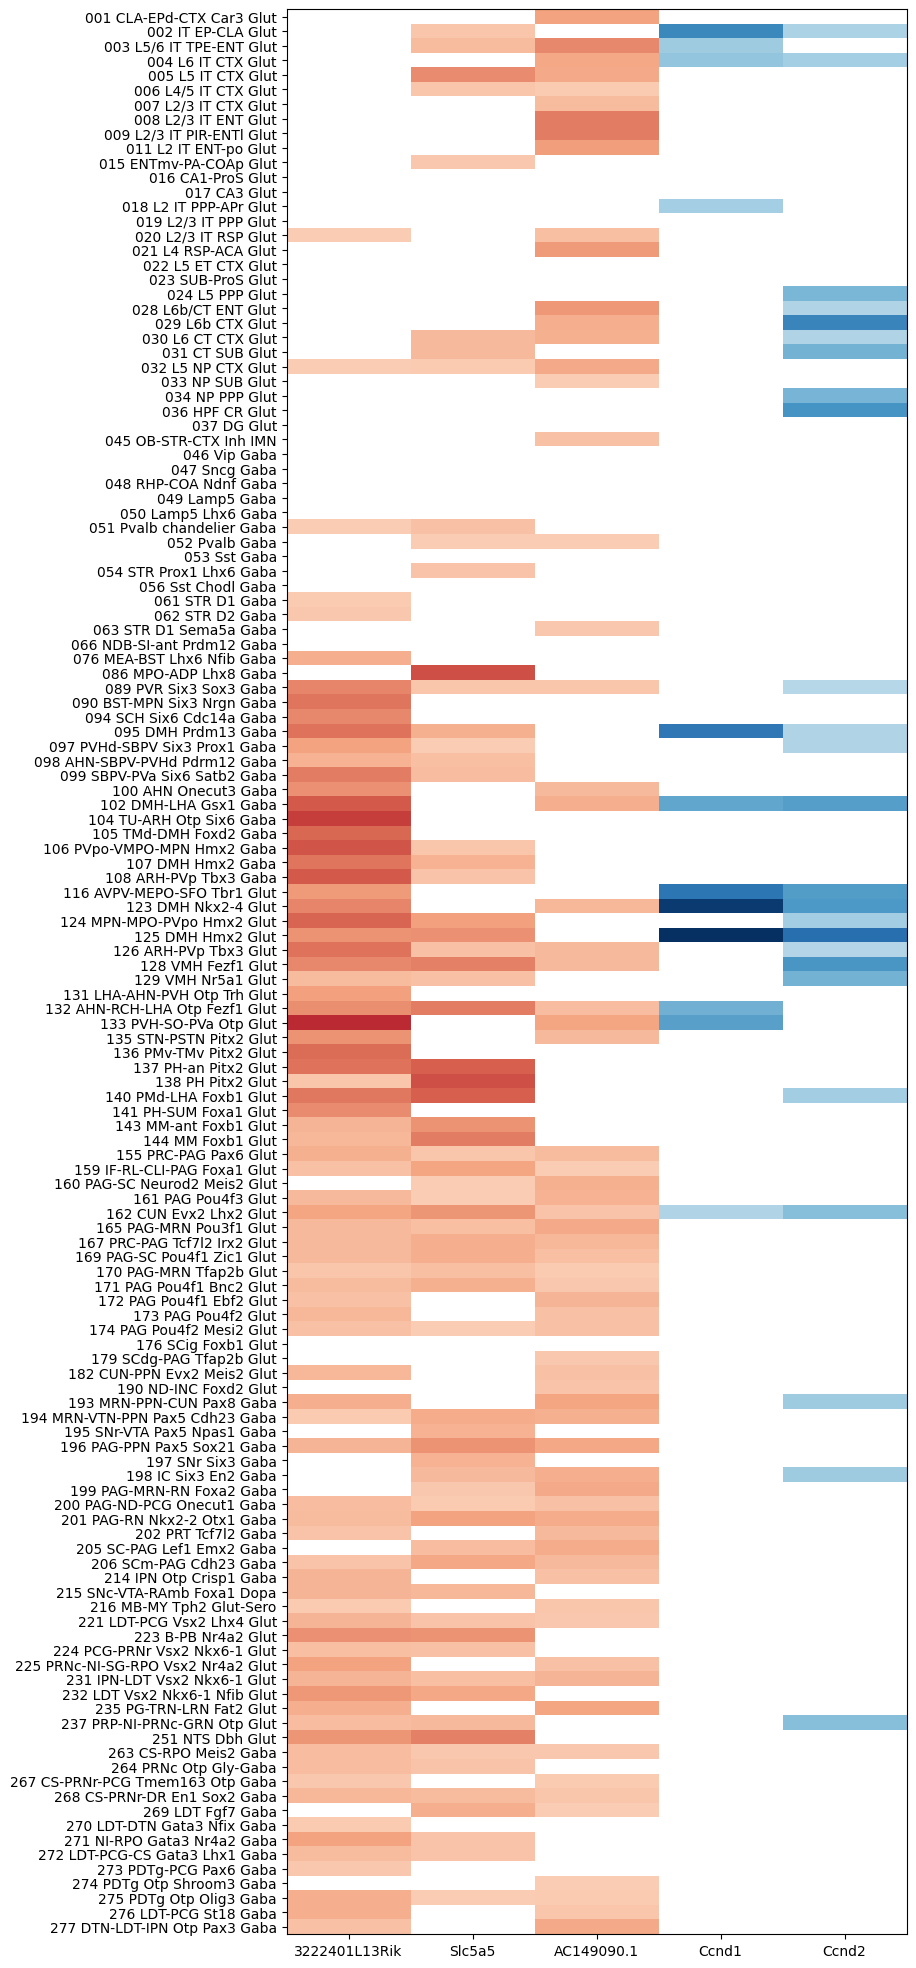

In [24]:
res = plot_heatmap(subclass_by_gene, 8, 25, cmap=plt.cm.RdBu_r, vmin=-4, vmax=4)
plt.show()

We can also plot the ageDE expression for the non-neuronal supertypes from Jin et al. Note that we show slightly different genes for the non-neuronal celltypes compared to our previous plot.

In [25]:
supertype_by_gene = get_genes_for_celltype_level(
    degene_df=degenes,
    level='supertype',
    degene_list=['3222401L13Rik', 'AC149090.1', 'Gm10076', 'Uba52', 'Ccnd2']
)
supertype_by_gene.head()

,3222401L13Rik,AC149090.1,Gm10076,Uba52,Ccnd2
1159 Astro-NT NN_1,NaN,1.606709,NaN,NaN,NaN
1160 Astro-NT NN_2,NaN,1.917127,NaN,NaN,NaN
1161 Astro-TE NN_1,NaN,2.299556,NaN,1.570618,-1.361851
1163 Astro-TE NN_3,1.117364,2.569296,NaN,1.169082,NaN
1165 Astro-TE NN_5,NaN,1.228538,1.000455,1.787092,NaN


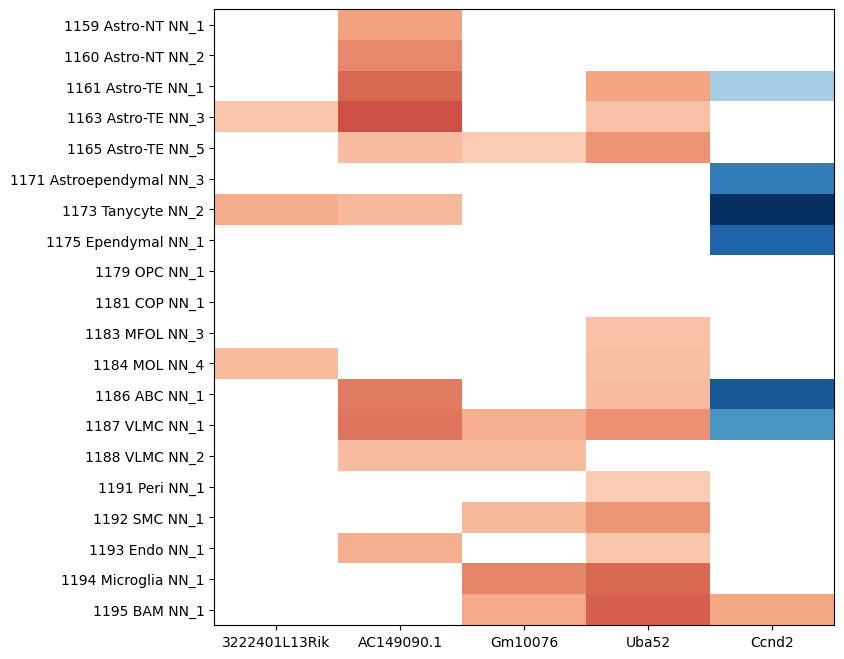

In [26]:
res = plot_heatmap(supertype_by_gene, 8, 8, cmap=plt.cm.RdBu_r, vmin=-4, vmax=4)
plt.show()